In [23]:
import sys
import scipy
import ast
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Maybe not needed?

# TODO:
    # [ ] Preprocessing
    # [ ] Unieke woorden tellen
    # [ ] TF*IDF
    # [ ] Clusteren
    # [ ] Bekijk topic per cluster
    # [ ] Visualiseer evolutie  over tijd


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sjt04\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sjt04\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sjt04\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
# Read input file and create table
records = []
with open("data/data_mining_publications.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line:
            records.append(ast.literal_eval(line))


table = pd.DataFrame(records)

# Get all titles
titles = table['title'].to_list()
table

,publication_type,booktitle,journal,year,title
0,inproceedings,SDM,,2019,Feature selection as Monte-Carlo Search in Gro...
1,inproceedings,SDM,,2002,Mining Relationship between Triggering and Con...
2,inproceedings,SDM,,2007,Segmentations with Rearrangements.
3,inproceedings,SDM,,2021,MT-STNets: Multi-Task Spatial-Temporal Network...
4,inproceedings,SDM,,2006,A Semantic Approach for Mining Hidden Links fr...
...,...,...,...,...,...
14480,inproceedings,KDD,,1996,Using a Hybrid Neural/Expert System for Data B...
14481,inproceedings,KDD,,2021,Table2Charts: Recommending Charts by Learning ...
14482,inproceedings,KDD,,2021,Physical Equation Discovery Using Physics-Cons...
14483,inproceedings,KDD,,2023,Accelerating Personalized PageRank Vector Comp...


In [25]:
# Initialize stemmer
ps: PorterStemmer = PorterStemmer()

# Other option (below): lemmatization
# This returns valid words, but can only be done on one type (eg. nouns or verbs), 
# so others will still create duplicates

# from nltk.stem import WordNetLemmatizer
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# wnl = WordNetLemmatizer()

# Get English stop words and punctuation dict
stop_words = set(stopwords.words('english'))
punct = str.maketrans(dict.fromkeys(string.punctuation))

filtered_titles: list[list[str]] = []
unique_word_counts: defaultdict[str, int] = defaultdict(int)
total_words: int = 0

for title in titles:
    # Set string to lowercase and remove punctuation
    title_words = word_tokenize(title.lower().translate(punct))

    # Remove stopwords and stem each word
    filtered_title = [ps.stem(word) for word in title_words if word not in stop_words]
    # filtered_title = [wnl.lemmatize(word, pos="v") for word in title_words if word not in stop_words]
    # filtered_title = [word for word in title_words if word not in stop_words]
    filtered_titles.append(filtered_title)
    total_words += len(filtered_title)
    
    for word in filtered_title:
        unique_word_counts[word] += 1


print(f"Total words: {total_words}, unique words: {len(unique_word_counts)}")

Total words: 97786, unique words: 9669


In [26]:
# This part creates a TF*IDF matrix (can be used for clustering later on!)
tfidf_titles = [" ".join(tokens) for tokens in filtered_titles]

vec = TfidfVectorizer(lowercase=False,  # we already lowercased/stemmed tokens
                      token_pattern=r"(?u)\b\w+\b",
                      smooth_idf=True,  # add 1 to numerator/denominator (stability)
                      use_idf=True)

tfidf_matrix = vec.fit_transform(tfidf_titles)
vocab = vec.get_feature_names_out()
# print("n docs, vocab size:", tfidf_matrix.shape)

In [27]:
# Test TF*IDF matrix
i = 0
row = tfidf_matrix.getrow(i)
indices = row.indices
data = row.data
top_n = 10
order = data.argsort()[::-1][:top_n]
for pos in order:
    print(vocab[indices[pos]], data[pos])

leaf 0.3827972514282151
acycl 0.3671000211130385
montecarlo 0.35596265896147644
grow 0.3204892572648419
root 0.31033205211090426
singl 0.2882439023061207
best 0.2834974596441657
direct 0.24406442093090747
identif 0.23718564811915677
search 0.18717256659593434


In [ ]:
# Agglomerative clustering
# Too slow

n_clusters = 5
print("Converting to dense array for clustering...")
tfidf_dense = tfidf_matrix.toarray()

aggl_clust = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',  # Much faster than cosine
    linkage='ward'  # Ward works with euclidean and is efficient
)

# Fit and predict clusters
print("Fitting agglomerative clustering...")
cluster_labels = aggl_clust.fit_predict(tfidf_dense)


In [ ]:
# BERT embeddings
# see test_bertopic.py for correct version

import ast
import bertopic
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

processed_titles = []
for token in filtered_titles:
    processed_titles.append(" ".join(token))

topic_model = bertopic.BERTopic()
topics, probs = topic_model.fit_transform(processed_titles)

info = topic_model.get_topic_info()
print(info)


     Topic  Count                                   Name  \
0       -1   5560          -1_cluster_data_graph_predict   
1        0    344        0_social_media_influenc_twitter   
2        1    337             1_seri_time_warp_multivari   
3        2    301     2_multilabel_label_partial_classif   
4        3    201             3_neural_deep_recurr_train   
..     ...    ...                                    ...   
186    185     11   185_reduct_dimension_discrimin_space   
187    186     11  186_disentangl_align_disenqnet_detach   
188    187     10      187_larg_arbitrari_shape_apporach   
189    188     10               188_urban_area_map_baidu   
190    189     10  189_sensor_coevolv_longlead_powercast   

                                        Representation  \
0    [cluster, data, graph, predict, gener, model, ...   
1    [social, media, influenc, twitter, viral, netw...   
2    [seri, time, warp, multivari, timeseri, motif,...   
3    [multilabel, label, partial, classif, unla


Top 10 topics

Created 29 overlapping intervals of 3 years with 2-year overlap


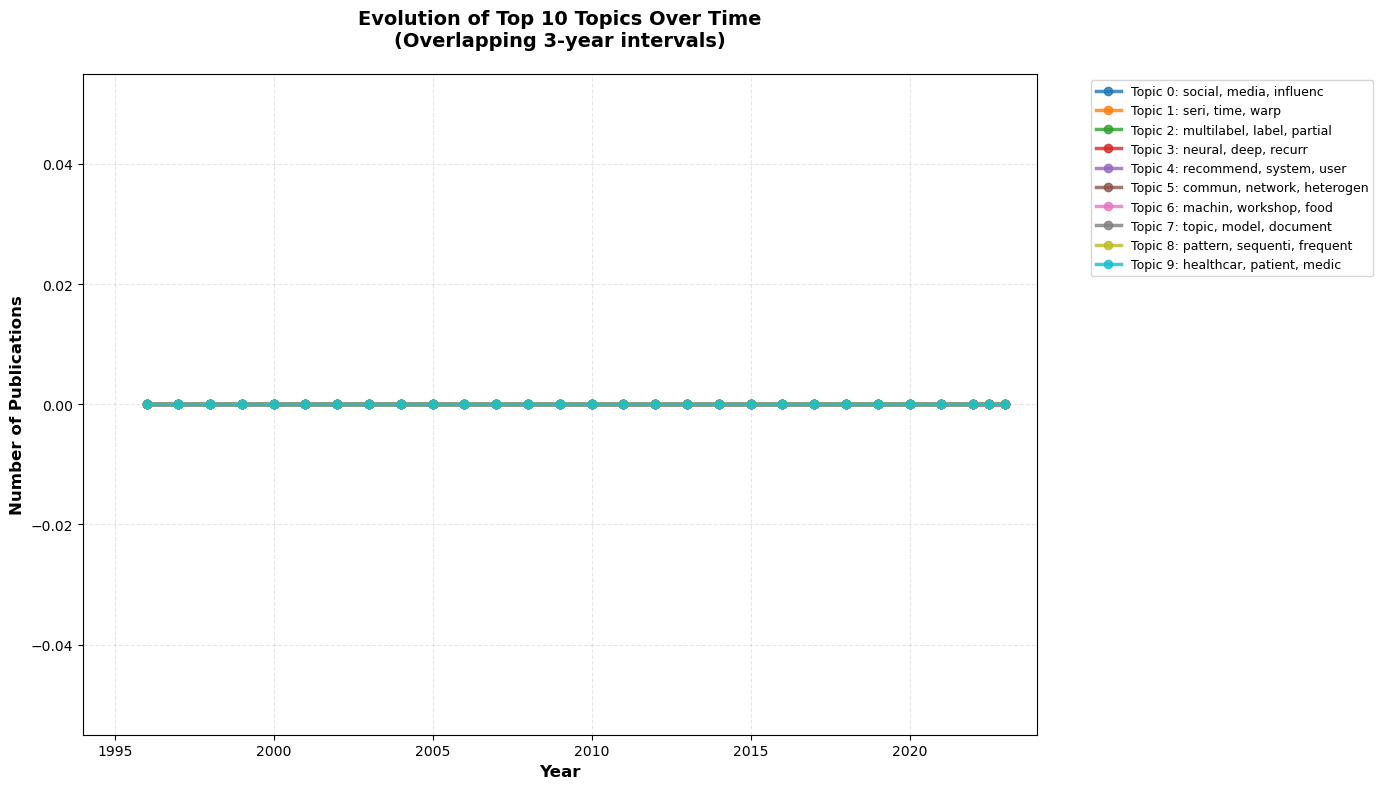


Saved: topic_evolution.png


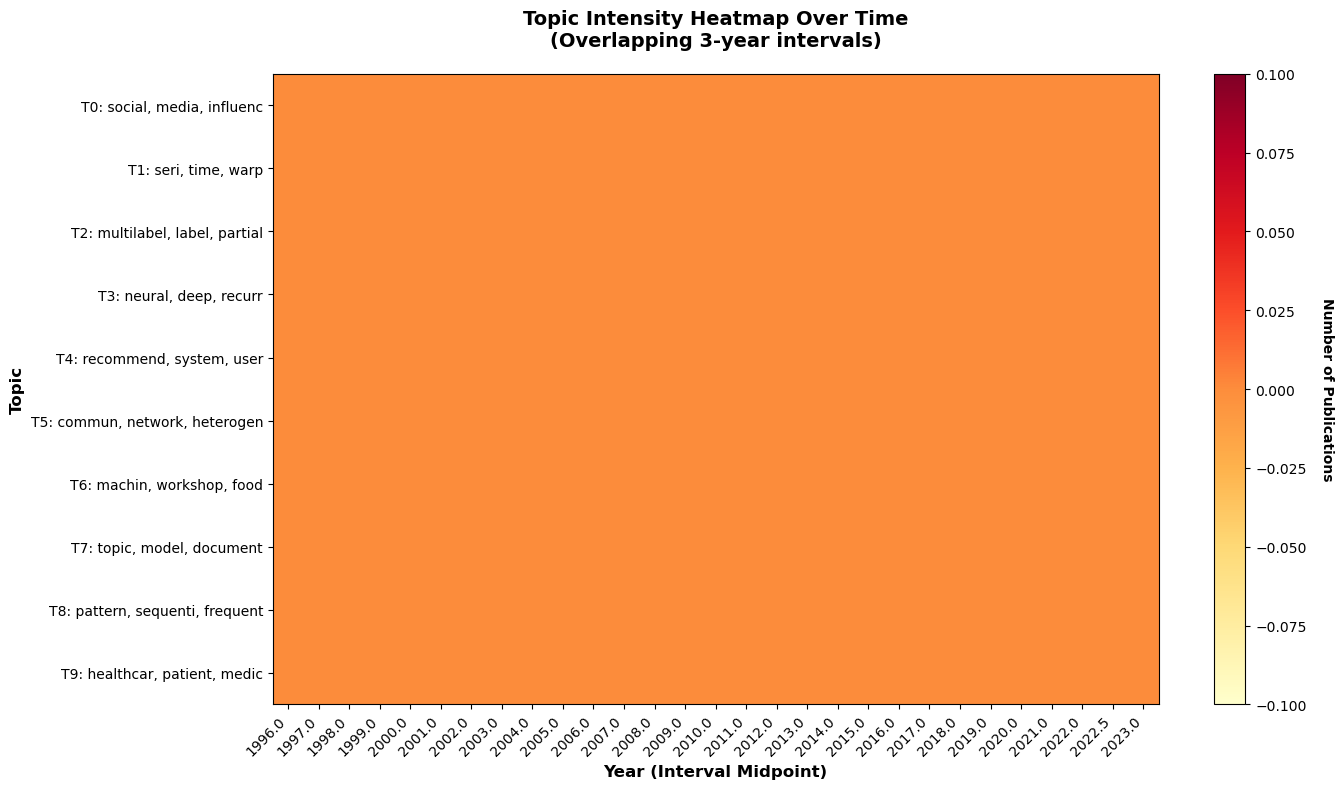

Saved: topic_heatmap.png


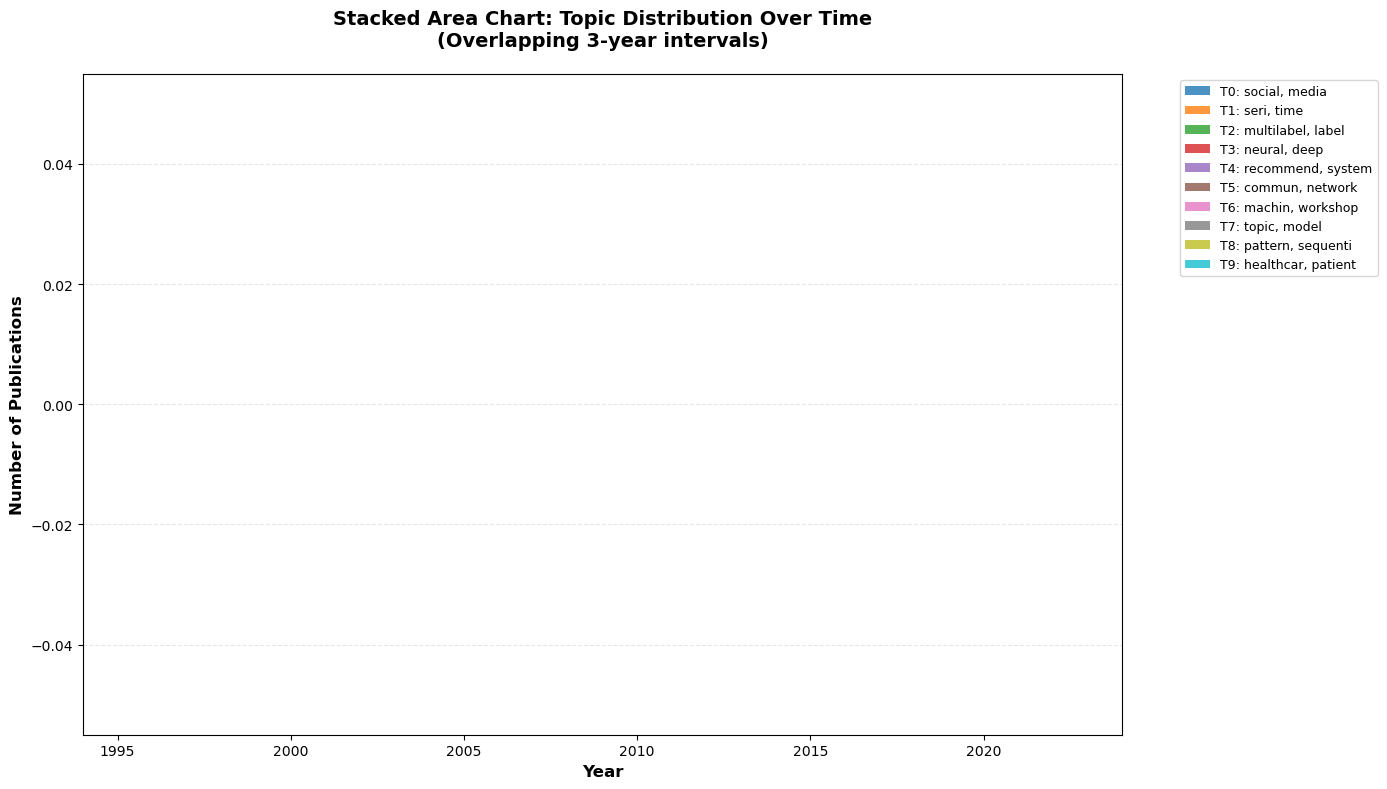

Saved: topic_stacked_area.png

=== Detailed Topic Evolution Statistics ===

Topic 0: social, media, influenc, twitter, viral
  Total publications: 0
  Peak interval: 1996.0 (0 pubs)
  Average per interval: 0.0
  Trend: decreasing (0.00 pubs/interval)

Topic 1: seri, time, warp, multivari, timeseri
  Total publications: 0
  Peak interval: 1996.0 (0 pubs)
  Average per interval: 0.0
  Trend: decreasing (0.00 pubs/interval)

Topic 2: multilabel, label, partial, classif, unlabel
  Total publications: 0
  Peak interval: 1996.0 (0 pubs)
  Average per interval: 0.0
  Trend: decreasing (0.00 pubs/interval)

Topic 3: neural, deep, recurr, train, vision
  Total publications: 0
  Peak interval: 1996.0 (0 pubs)
  Average per interval: 0.0
  Trend: decreasing (0.00 pubs/interval)

Topic 4: recommend, system, user, coldstart, prefer
  Total publications: 0
  Peak interval: 1996.0 (0 pubs)
  Average per interval: 0.0
  Trend: decreasing (0.00 pubs/interval)

Topic 5: commun, network, heterogen, detec

In [ ]:
# Visualize topics
# see test_bertopic.py for correct version

#get topics with dates
dates = table['year'].to_list()
date_topics = defaultdict(list)
for date, topic in zip(dates, topics):
    date_topics[date].append(topic)

n = 10  
n_topics = info[info['Topic'] != -1].nlargest(n, 'Count')['Topic'].tolist()

print(f"\nTop {n} topics")

# Filter data
plot_data = table[table['title'].isin(n_topics)].copy()
